In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Input, BatchNormalization, Add, ReLU, 
    Conv2DTranspose, Multiply, GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, 
    auc, precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle



In [2]:
# 参数设置
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS_PRETRAIN = 30
EPOCHS_FINETUNE = 40
NUM_CLASSES = 5
MASK_RATIO = 0.25
LEARNING_RATE = 0.0001
MIN_LR = 1e-5    

CSV_PATH = r'E:\Univercity_all\Leve4_shang\OBU\FinalProject\aptos2019-blindness-detection\train_balanced_fixed.csv'
IMAGE_DIR = r'E:\Univercity_all\Leve4_shang\OBU\FinalProject\aptos2019-blindness-detection\train_images_processed'

In [3]:
def prepare_data():
    # 读取并处理CSV
    df = pd.read_csv(CSV_PATH)
    
    # 处理文件名
    df['id_code'] = df['id_code'].apply(
        lambda x: f"{x}.png" if not str(x).endswith(".png") else x)
    df['id_code'] = df['id_code'].str.replace(".png.png", ".png")
    
    #df['diagnosis'] = df['diagnosis'].astype(int)
    # 保持标签为原始字符串格式
    df['diagnosis'] = df['diagnosis'].astype(str)  # 确保为字符串
    
    # 分层划分数据集
    train_df, valid_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['diagnosis'], 
        random_state=42
    )
    return train_df, valid_df

from tensorflow.keras.utils import load_img
from PIL import ImageFile

# 启用“加载部分图片”的容错机制
ImageFile.LOAD_TRUNCATED_IMAGES = True

def create_datagen(augment=False):
    if augment:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=25,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
            fill_mode='constant'
        )
    return ImageDataGenerator(rescale=1./255)


In [4]:
# GuCNN模块定义
#残差块
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), padding="same", kernel_regularizer=l2(1e-3))(shortcut)
    
    x = Conv2D(filters, (kernel_size, kernel_size), padding="same", kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (kernel_size, kernel_size), padding="same", kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    return ReLU()(x)
    
#GuCNN
def build_encoder():
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    
    # 下采样阶段
    x = residual_block(inputs, 32)
    x = MaxPooling2D(2)(x)  

    x = residual_block(x, 64)
    x = MaxPooling2D(2)(x)  # 56x56

    x = residual_block(x, 128)
    x = MaxPooling2D(2)(x)  # 28x28

    # x = residual_block(x, 256)
    # x = MaxPooling2D(2)(x)  # 14x14
    
    # x = residual_block(x, 512)
    # x = MaxPooling2D(2)(x)  # 14x14
    
    
    return Model(inputs, x, name="GuCNN_Encoder")

In [5]:
import tensorflow.keras.backend as K
#掩码自编码
def build_mae(encoder):
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    
    # 随机掩码
    # mask = tf.random.uniform(tf.shape(inputs)[:-1]) > MASK_RATIO
    # mask = tf.expand_dims(mask, -1)
    # masked_inputs = Multiply()([inputs, tf.cast(mask, tf.float32)])

    mask = tf.cast(tf.random.uniform(tf.shape(inputs)[:-1]) > MASK_RATIO, tf.float32)
    mask = tf.expand_dims(mask, -1)
    masked_inputs = Multiply()([inputs, mask])
    
    # 编码
    encoded = encoder(masked_inputs)  
    
    # 解码器
    # x = Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(encoded)  # 28x28
    # x = Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)       # 56x56
    x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(encoded)       # 112x112
    x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)        # 224x224
    x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)       

    outputs = Conv2D(3, 3, activation='sigmoid', padding='same')(x)
    outputs = K.cast(outputs, dtype='float32') 
    
    return Model(inputs, outputs, name="MAE")

In [6]:
# 启用混合精度
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 数据准备与生成器
train_df, valid_df = prepare_data()

train_datagen_pretrain = create_datagen(augment=True)
valid_datagen_pretrain = create_datagen(augment=False)

train_pretrain_flow = train_datagen_pretrain.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col="id_code",
    y_col=None,  # 自监督不加载标签
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="input",  # 输入即目标
    shuffle=True
)

valid_pretrain_flow = valid_datagen_pretrain.flow_from_dataframe(
    dataframe=valid_df,
    directory=IMAGE_DIR,
    x_col="id_code",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="input",
    shuffle=False
)

# 构建预训练模型
encoder = build_encoder()
mae = build_mae(encoder)

# 验证模型输入输出形状
print("\n[预训练阶段验证]")
print(f"MAE输入形状: {mae.input_shape}")
print(f"MAE输出形状: {mae.output_shape}")
sample_x, sample_y = next(train_pretrain_flow)
print(f"数据输入形状: {sample_x.shape} (应{IMG_SIZE}x{IMG_SIZE}x3)")
print(f"目标形状: {sample_y.shape} (应与输入相同)")

# 编译并训练预训练模型
mae.compile(optimizer=Adam(LEARNING_RATE, clipvalue=0.5), loss='mse')
print("\nMAE预训练中...")

mae.fit(
    train_pretrain_flow,
    validation_data=valid_pretrain_flow,  
    epochs=EPOCHS_PRETRAIN,
    steps_per_epoch=len(train_pretrain_flow), 
    validation_steps=len(valid_pretrain_flow),  
    callbacks=[
        EarlyStopping(patience=4, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=3)
    ]
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


F:\Anaconda\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 14 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 7283 validated image filenames.
Found 1825 validated image filenames.

[预训练阶段验证]
MAE输入形状: (None, 224, 224, 3)
MAE输出形状: (None, 224, 224, 3)
数据输入形状: (8, 224, 224, 3) (应224x224x3)
目标形状: (8, 224, 224, 3) (应与输入相同)

MAE预训练中...
Epoch 1/30
911/911 [==============================] - 1182s 1s/step - loss: 0.1609 - val_loss: 0.0493 - lr: 1.0000e-04
Epoch 2/30
911/911 [==============================] - 1174s 1s/step - loss: 0.0206 - val_loss: 0.0143 - lr: 1.0000e-04
Epoch 3/30
911/911 [==============================] - 1171s 1s/step - loss: 0.0058 - val_loss: 0.0073 - lr: 1.0000e-04
Epoch 4/30
911/911 [==============================] - 1169s 1s/step - loss: 0.0029 - val_loss: 0.0041 - lr: 1.0000e-04
Epoch 5/30
911/911 [==============================] - 1175s 1s/step - loss: 0.0023 - val_loss: 0.0048 - lr: 1.0000e-04
Epoch 6/30
911/911 [==============================] - 1176s 1s/step - loss: 0.0038 - val_loss: 0.0095 - lr: 1.0000e-04
Epoch 7/30
911/911 [==============================] - 1175s

#分类模型
# def build_classifier(encoder):
#     # 部分解冻编码器
#     for layer in encoder.layers[-6:]:
#         if not isinstance(layer, BatchNormalization):
#             layer.trainable = True
    
#     x = GlobalAveragePooling2D()(encoder.output)
#     x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-3))(x)
#     x = Dropout(0.6)(x)
#     outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
#     return Model(encoder.input, outputs, name="Classifier")

    # 修改分类模型构建函数
def build_classifier(encoder):
    # 部分解冻编码器
    # for layer in encoder.layers[-3:]:
    #     if not isinstance(layer, BatchNormalization):
    #         layer.trainable = True

    # 先冻结整个编码器，再有选择性地解冻部分层
    for layer in encoder.layers:
        layer.trainable = False
    # 逐步解冻最后几层（非 BatchNormalization 层）
    for layer in encoder.layers[-5:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
        
    x = GlobalAveragePooling2D()(encoder.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x) 
        
    return Model(encoder.input, outputs, name="Classifier")
    

In [7]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [8]:
#监督微调部分
# 对训练集进行平衡采样（每个类别选取n张图片，不足时采用放回采样）
def get_balanced_dataframe(df, n=100):
    balanced_list = []
    classes = sorted(df['diagnosis'].unique())
    for cls in classes:
        df_cls = df[df['diagnosis'] == cls]
        if len(df_cls) < n:
            df_sample = df_cls.sample(n, replace=True, random_state=42)
        else:
            df_sample = df_cls.sample(n, replace=False, random_state=42)
        balanced_list.append(df_sample)
    balanced_df = pd.concat(balanced_list)
    return balanced_df

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, generator):
    y_true = generator.labels
    y_pred = model.predict(generator).argmax(axis=1)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_proba = model.predict(generator)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(NUM_CLASSES)]))
    
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(NUM_CLASSES),
                yticklabels=range(NUM_CLASSES))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10,8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(10,8))
    for i, color in zip(range(NUM_CLASSES), colors):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
        avg_precision = average_precision_score(y_true_bin[:, i], y_proba[:, i])
        plt.plot(recall, precision, color=color,
                 label=f'Class {i} (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="best")
    plt.show()

def smooth_labels(y_true, num_classes, smoothing=0.1):
    # 如果 y_true 多了一个维度，则 squeeze 去掉最后一维
    if len(tf.shape(y_true)) > 1:
        y_true = tf.squeeze(y_true, axis=-1)
    # 生成 one-hot 标签，形状为 (batch_size, num_classes)
    y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)
    confidence = 1.0 - smoothing
    # 构造与 one-hot 标签相同形状的平滑张量
    smooth = tf.ones_like(y_true_onehot, dtype=tf.float32) * (smoothing / (num_classes - 1))
    return confidence * y_true_onehot + smooth
    
# loss = lambda y_true, y_pred: tf.keras.losses.categorical_crossentropy(
#     smooth_labels(y_true, NUM_CLASSES, smoothing=0.1), y_pred
# )

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)


# 数据准备与生成器
train_df, valid_df = prepare_data()

train_datagen_finetune = create_datagen(augment=True)
valid_datagen_finetune = create_datagen(augment=False)

# 对训练集进行平衡采样（此步骤可选）
balanced_train_df = get_balanced_dataframe(train_df, n=200)
print("\n监督微调使用的平衡训练集样本分布：")
print(balanced_train_df['diagnosis'].value_counts())

train_finetune_flow = train_datagen_finetune.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col="id_code",
    y_col="diagnosis",  # 加载标签
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    #class_mode="sparse",
    class_mode="categorical",
    shuffle=True
)

print("\n验证标签类型:")
print(f"标签列数据类型: {train_df['diagnosis'].dtype}")
print(f"标签示例值: {train_df['diagnosis'].iloc[:5].values}")

valid_finetune_flow = valid_datagen_finetune.flow_from_dataframe(
    dataframe=valid_df,
    directory=IMAGE_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    #class_mode="sparse",
    class_mode="categorical",
    shuffle=False
)

print("\n[微调阶段验证]")
sample_x, sample_y = next(train_finetune_flow)
print(f"输入数据形状: {sample_x.shape} (应{IMG_SIZE}x{IMG_SIZE}x3)")
print(f"标签形状: {sample_y.shape} (应({BATCH_SIZE},))")
print(f"标签值示例: {sample_y[:5]} (应0-4范围内的整数)")



监督微调使用的平衡训练集样本分布：
diagnosis
0    200
1    200
2    200
3    200
4    200
Name: count, dtype: int64


F:\Anaconda\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 14 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 7283 validated image filenames belonging to 5 classes.

验证标签类型:
标签列数据类型: object
标签示例值: ['3' '3' '4' '0' '4']
Found 1825 validated image filenames belonging to 5 classes.

[微调阶段验证]
输入数据形状: (8, 224, 224, 3) (应224x224x3)
标签形状: (8, 5) (应(8,))
标签值示例: [[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]] (应0-4范围内的整数)


In [9]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

class WarmUpCosineDecay(LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps, min_lr=1e-5):
        super().__init__()
        self.base_lr = tf.cast(base_lr, tf.float32)
        self.total_steps = tf.cast(total_steps, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.min_lr = tf.cast(min_lr, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # 线性 warmup 阶段
        warmup_lr = self.base_lr * (step / self.warmup_steps)

        # cosine decay 阶段
        decay_step = tf.minimum(step - self.warmup_steps, self.total_steps - self.warmup_steps)
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * decay_step / (self.total_steps - self.warmup_steps)))
        cosine_lr = (self.base_lr - self.min_lr) * cosine_decay + self.min_lr

        # 如果在 warmup 阶段，就使用 warmup lr，否则使用 decay lr
        return tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: cosine_lr)

    def get_config(self):
        return {
            "base_lr": float(self.base_lr.numpy()),
            "total_steps": float(self.total_steps.numpy()),
            "warmup_steps": float(self.warmup_steps.numpy()),
            "min_lr": float(self.min_lr.numpy()),
        }


In [10]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        # 处理学习率调度器返回的是一个 schedule 的情况
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_step = self.model.optimizer.iterations.numpy()
            lr = float(lr(current_step))
        else:
            lr = float(tf.keras.backend.get_value(lr))
        print(f"Epoch {epoch + 1}: Learning rate is {lr:.6f}")


In [11]:
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import LearningRateScheduler



分类模型结构:
Model: "Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d_1[0][0]']               
 alization)                     )                                               

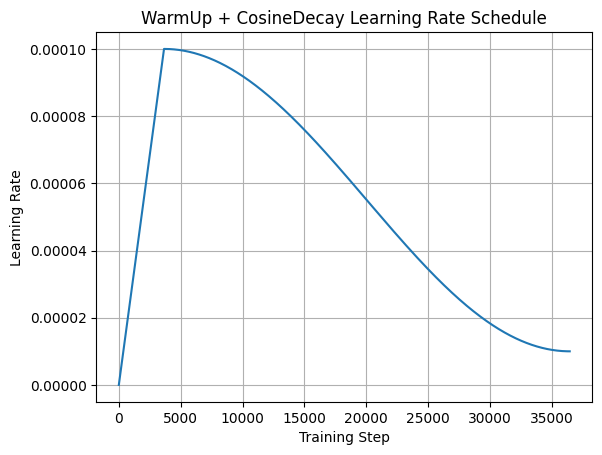


分类微调中...
Epoch 1/40
911/911 [==============================] - 1155s 1s/step - loss: 1.3711 - accuracy: 0.4951 - val_loss: 1.3204 - val_accuracy: 0.5551
Epoch 2/40
911/911 [==============================] - 1161s 1s/step - loss: 1.0369 - accuracy: 0.7090 - val_loss: 0.9638 - val_accuracy: 0.7956
Epoch 3/40
911/911 [==============================] - 1159s 1s/step - loss: 0.9394 - accuracy: 0.7714 - val_loss: 0.8626 - val_accuracy: 0.8460
Epoch 4/40
911/911 [==============================] - 1152s 1s/step - loss: 0.8566 - accuracy: 0.8269 - val_loss: 0.7979 - val_accuracy: 0.8608
Epoch 5/40
911/911 [==============================] - 1156s 1s/step - loss: 0.8077 - accuracy: 0.8517 - val_loss: 1.0270 - val_accuracy: 0.7173
Epoch 6/40
911/911 [==============================] - 1141s 1s/step - loss: 0.7774 - accuracy: 0.8579 - val_loss: 0.7489 - val_accuracy: 0.8762
Epoch 7/40
911/911 [==============================] - 1141s 1s/step - loss: 0.7467 - accuracy: 0.8745 - val_loss: 0.7262 - val

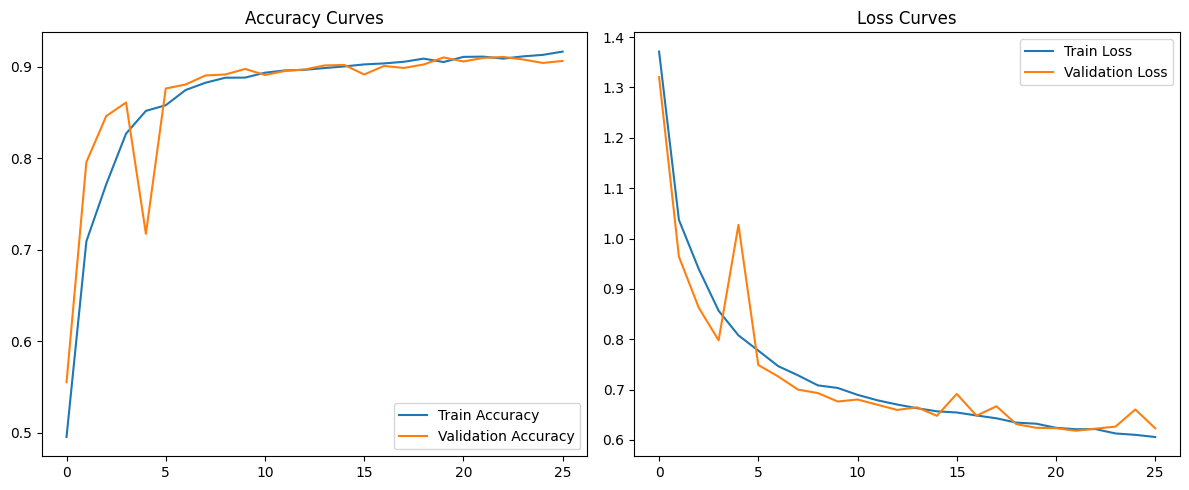


最终模型评估：
229/229 [==============================] - 216s 941ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       361
           1       0.92      0.90      0.91       361
           2       0.78      0.92      0.84       381
           3       0.99      0.90      0.94       361
           4       0.98      0.86      0.92       361

    accuracy                           0.91      1825
   macro avg       0.92      0.91      0.91      1825
weighted avg       0.92      0.91      0.91      1825



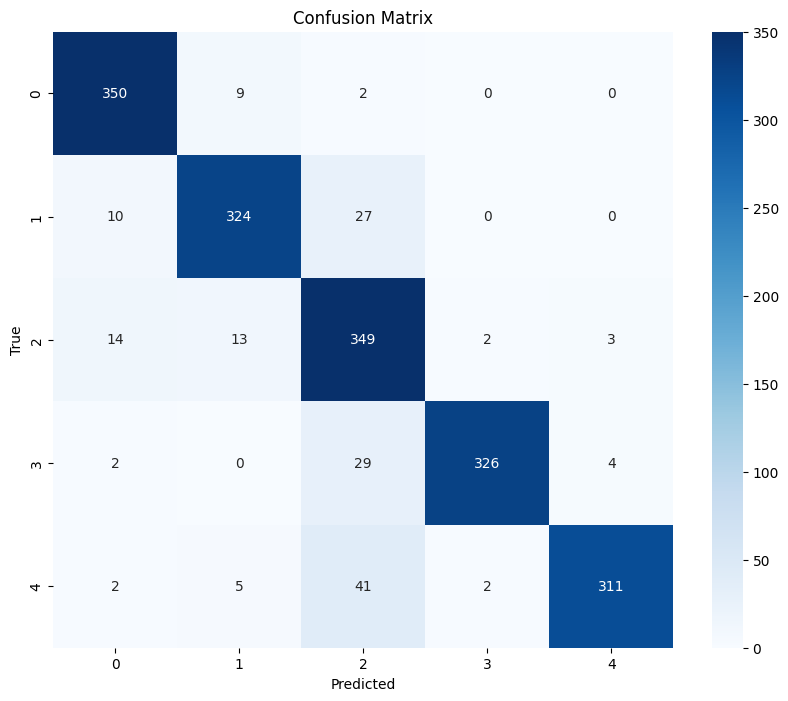

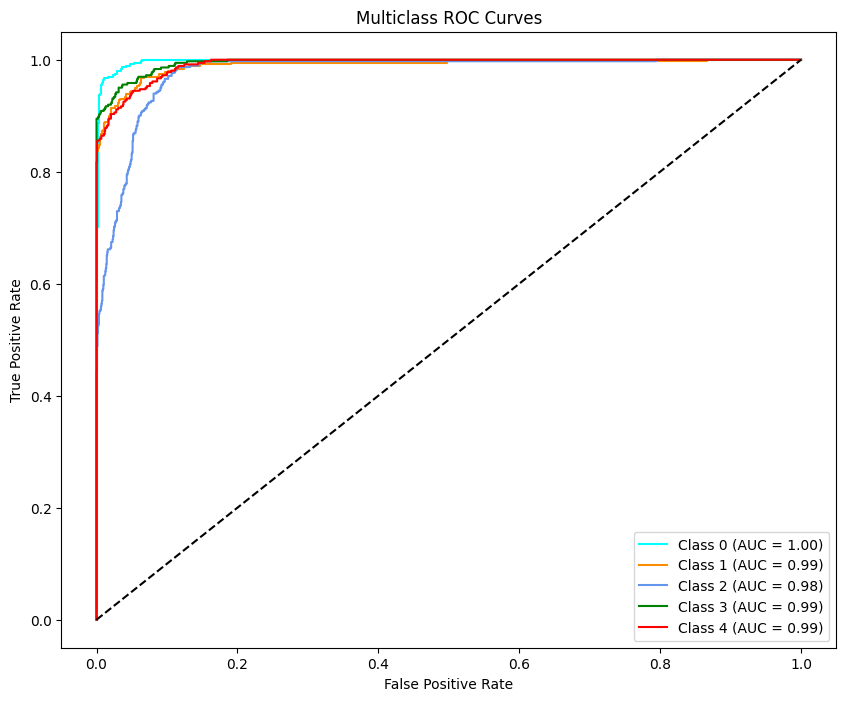

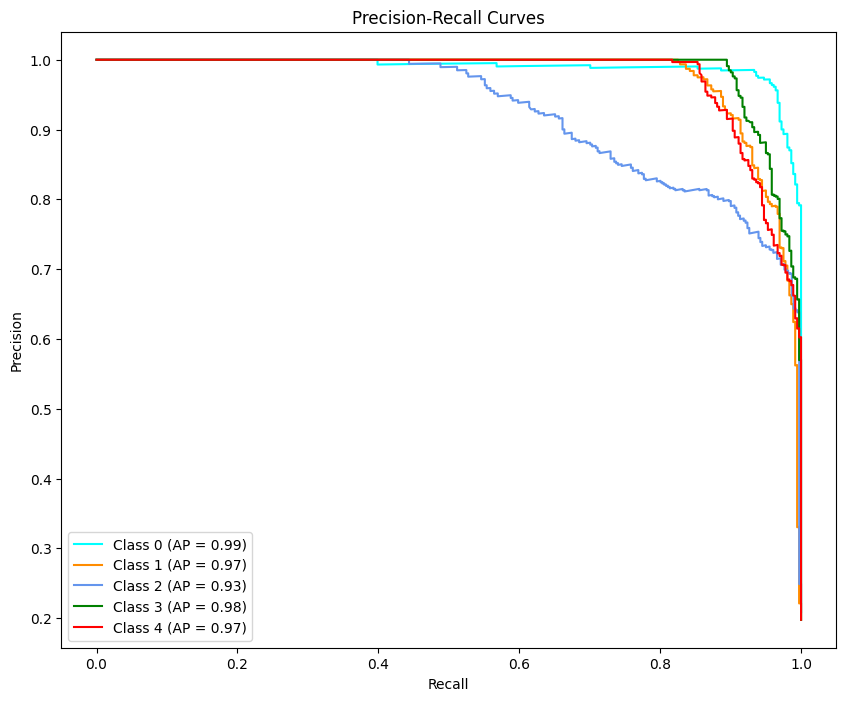


模型已保存为 dr_classifier_final.h5


In [12]:
# 构建分类模型（注意这里使用上面预训练得到的 encoder 变量）
def build_classifier(encoder):
    # 先冻结整个编码器，再逐步解冻部分层（非 BatchNormalization 层）
    for layer in encoder.layers:
        layer.trainable = False
    for layer in encoder.layers[-10:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
        
    x = GlobalAveragePooling2D()(encoder.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
        
    return Model(encoder.input, outputs, name="Classifier")

# 使用预训练的 encoder 构建分类模型
classifier = build_classifier(encoder)

print("\n分类模型结构:")
classifier.summary()

#total_steps = EPOCHS_FINETUNE * len(train_finetune_flow)

#lr_schedule = tf.keras.experimental.CosineDecay(
# lr_schedule = CosineDecay(
#     initial_learning_rate=LEARNING_RATE,
#     decay_steps=total_steps,
#     alpha=1e-5
# )

steps_per_epoch = len(train_finetune_flow)
total_steps = EPOCHS_FINETUNE * steps_per_epoch
warmup_steps = int(0.1 * total_steps) # 10% 用于warmup

MIN_LR = 1e-5         # 最小学习率

lr_schedule = WarmUpCosineDecay(base_lr=LEARNING_RATE, total_steps=total_steps, warmup_steps=warmup_steps, min_lr=MIN_LR)

import matplotlib.pyplot as plt

lrs = [lr_schedule(step).numpy() for step in range(total_steps)]

plt.plot(lrs)
plt.title("WarmUp + CosineDecay Learning Rate Schedule")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


# cosine_decay = CosineDecay(
#     initial_learning_rate=LEARNING_RATE,  # 定义的初始学习率
#     decay_steps=total_steps,
#     alpha=1e-5  # 最小lr占初始lr的比例
# )

# def scheduler(epoch, lr):
#     current_step = epoch * steps_per_epoch
#     return float(cosine_decay(current_step))  # 返回数值而不是 Tensor



classifier.compile(
    #optimizer=Adam(learning_rate=lr_schedule),
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    #optimizer = Adam(learning_rate=LEARNING_RATE),
    loss=loss,
    metrics=['accuracy']
)



print("\n分类微调中...")


history = classifier.fit(
    train_finetune_flow,
    validation_data=valid_finetune_flow,
    epochs=EPOCHS_FINETUNE,
    #steps_per_epoch=len(train_finetune_flow),
    steps_per_epoch=steps_per_epoch,
    validation_steps=len(valid_finetune_flow),
    callbacks=[
        EarlyStopping(patience=4, restore_best_weights=True),
        #ReduceLROnPlateau(factor=0.2, patience=3),
        #LearningRateScheduler(scheduler),  # 加在 callback 列表里
        LearningRateLogger()
    ]
)

plot_training_history(history)
print("\n最终模型评估：")
evaluate_model(classifier, valid_finetune_flow)
classifier.save(r"E:\Univercity_all\Leve4_shang\OBU\FinalProject\model\dr_classifier_final.h5")
print("\n模型已保存为 dr_classifier_final.h5")

def evaluate_model(model, generator):
    """综合模型评估"""
    # 获取预测结果
    y_true = generator.labels
    y_pred = model.predict(generator).argmax(axis=1)
    y_pred = tf.cast(y_pred, dtype=tf.float32)  # 转回 float32
    y_proba = model.predict(generator)
    
    # 分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(NUM_CLASSES)]))
    
    # 混淆矩阵
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(NUM_CLASSES),
                yticklabels=range(NUM_CLASSES))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC曲线
    y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10,8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall曲线
    plt.figure(figsize=(10,8))
    for i, color in zip(range(NUM_CLASSES), colors):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
        avg_precision = average_precision_score(y_true_bin[:, i], y_proba[:, i])
        plt.plot(recall, precision, color=color,
                 label=f'Class {i} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="best")
    plt.show()

def smooth_labels(y_true, num_classes, smoothing=0.1):
    """
    手动进行标签平滑
    :param y_true: 真实标签 (batch_size,)
    :param num_classes: 分类数
    :param smoothing: 平滑系数
    :return: 平滑后的 one-hot 标签
    """
    confidence = 1.0 - smoothing
    label_shape = tf.shape(y_true)
    smooth = tf.ones_like(y_true, dtype=tf.float32) * (smoothing / (num_classes - 1))
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)  # 确保是 one-hot
    return confidence * y_true + smooth
    
loss = lambda y_true, y_pred: tf.keras.losses.categorical_crossentropy(
    smooth_labels(y_true, NUM_CLASSES, smoothing=0.1), y_pred
)